In [107]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from datetime import datetime
import numpy as np

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [108]:
def get_Data(symbols, start_date, end_date):
    # Create an empty dictionary to store the data
    data = {}

    # Iterate over the symbols and load the data
    for symbol in symbols:
        try:
            # Use pandas_datareader to load the data from Yahoo Finance
            df = pdr.get_data_yahoo(symbol, start_date, end_date,interval='1d')

            # Store the data in the dictionary
            data[symbol] = df

            print(f"Data loaded successfully for symbol: {symbol}")

        except Exception as e:
            print(f"Error loading data for symbol: {symbol}")
            print(str(e))
    return data



#  Geometric Brownian Motion Model

In [109]:
# Function to simulate next-day price based on the given equation
def simulate_next_day_price(current_price, mu, sig):
    Z = np.random.normal(0, 1)
    next_day_price = current_price * np.exp(mu - sig**2/2) + sig * Z
    return next_day_price

In [110]:
# Define the parameters
num_predictions = 63
num_simulations = 10000
window_size = 3209

# List of symbols for the financial datasets
symbols = ['AAPL']
# Set the start and end dates for the data
start_date = datetime(2010,1,1)
end_date = datetime(2022,12,31)
Stock_data = get_Data(symbols, start_date, end_date)


[*********************100%***********************]  1 of 1 completed
Data loaded successfully for symbol: AAPL


In [111]:
past_prices = Stock_data[symbols[0]]["Close"]
past_prices = np.log(past_prices)
# Perform predictions
predictions_GBM = []
for i in range(num_predictions):
    # Get the window of past observed stock prices
    window_prices = past_prices[-window_size:]
    
    # Calculate mean and standard deviation of daily returns
    mu = np.mean(np.diff(window_prices))
    sig = np.std(np.diff(window_prices))
    
    # Simulate a large number of prices
    simulated_prices = []
    for j in range(num_simulations):
        simulated_price = simulate_next_day_price(window_prices[-1], mu, sig)
        simulated_prices.append(simulated_price)
    
    # Take the average of simulated prices to predict the next-day price
    predicted_price = np.mean(simulated_prices)
    predictions_GBM.append(predicted_price)
    
    # Update the training dataset (move the window and add the actual price)
    actual_price = past_prices[window_size+i]  # Replace with actual price from the data
    past_prices = np.append(past_prices, actual_price)


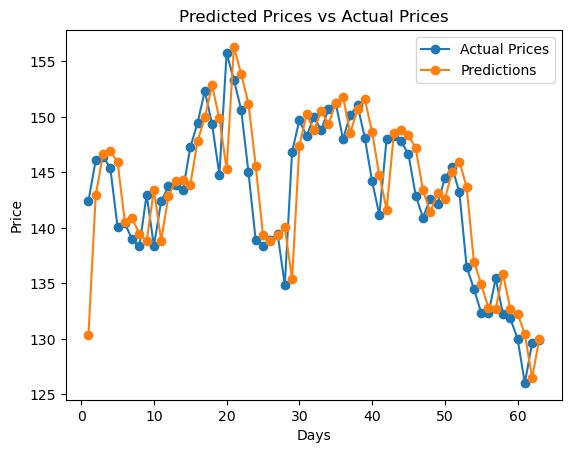

In [112]:
# Plotting
x = np.arange(1, num_predictions + 1)
plt.plot(x, np.exp(past_prices[-63:]), marker = 'o', label='Actual Prices')
plt.plot(x, np.exp(predictions_GBM), marker = 'o', label='Predictions')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Predicted Prices vs Actual Prices')
plt.legend()
plt.show()

# RNN

In [113]:
# Extract the 'Close' prices
stock_prices = Stock_data[symbols[0]]["Close"].values.reshape(-1, 1)

In [114]:
# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(stock_prices)

# Split the data into training and testing sets
train_size = int(len(scaled_prices) * 0.981)
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

In [115]:
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Define the number of time steps
time_steps = 1

# Prepare the training data
X_train, y_train = prepare_data(train_data, time_steps)

# Prepare the testing data
X_test, y_test = prepare_data(test_data, time_steps)


In [116]:
# Build the RNN model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
101/101 [==============================] - 7s 4ms/step - loss: 0.0471
Epoch 2/10
101/101 [==============================] - 1s 5ms/step - loss: 5.4595e-04
Epoch 3/10
101/101 [==============================] - 0s 5ms/step - loss: 2.9128e-04
Epoch 4/10
101/101 [==============================] - 1s 5ms/step - loss: 2.4133e-04
Epoch 5/10
101/101 [==============================] - 1s 5ms/step - loss: 1.9117e-04
Epoch 6/10
101/101 [==============================] - 1s 5ms/step - loss: 1.5215e-04
Epoch 7/10
101/101 [==============================] - 1s 5ms/step - loss: 1.1933e-04
Epoch 8/10
101/101 [==============================] - 1s 5ms/step - loss: 9.7252e-05
Epoch 9/10
101/101 [==============================] - 0s 5ms/step - loss: 8.2921e-05
Epoch 10/10
101/101 [==============================] - 0s 5ms/step - loss: 7.1278e-05


In [117]:
# Perform predictions on the test data
predictions_RNN = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions_RNN = scaler.inverse_transform(predictions_RNN)
y_test = scaler.inverse_transform(y_test)


2/2 [==============================] - 1s 11ms/step


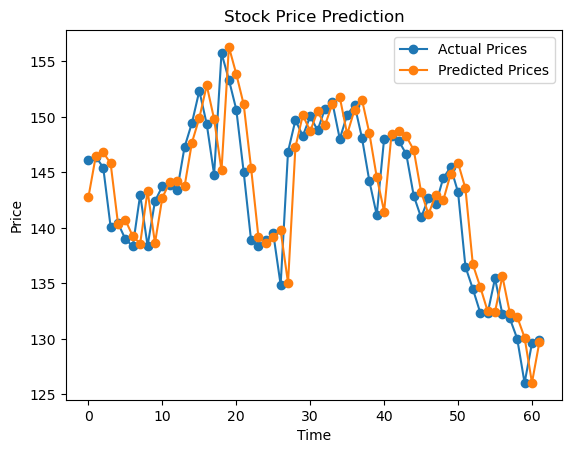

In [118]:
# Plot the predictions and actual values
plt.plot(y_test[-62:], marker = 'o', label='Actual Prices')
plt.plot(predictions_RNN, marker = 'o', label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()

In [119]:
def evaluate_forecasts(actual, predicted):
    mse = np.mean((actual - predicted)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - predicted))
    return mse, rmse, mae

mseGBM, rmseGBM, maeGBM = evaluate_forecasts(np.exp(past_prices[-62:]), np.exp(predictions_GBM[1:]))
mseRNN, rmseRNN, maeRNN = evaluate_forecasts(y_test[-62:], predictions_RNN)
table = [["GBM", mseGBM, rmseGBM, maeGBM],["RNN", mseRNN, rmseRNN, maeRNN]]
df = pd.DataFrame(table)
df.columns = ["Model", "MSE", "RMSE", "MAE"]
print(df)

  Model        MSE      RMSE       MAE
0   GBM  13.205069  3.633878  2.764842
1   RNN  13.151337  3.626477  2.737831
